# Treinamento da Rede Neural Classificadora:

In [11]:
# Instalação de pacotes necessários

%pip install numpy==2.2.6
%pip install matplotlib==3.10.3
%pip install torch
%pip install pandas==2.3.1
%pip install scikit-learn==1.7.1
%pip install seaborn==0.13.2

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ---------------------------------------- 0.0/8.7 MB ? eta -:--:--
   --------- ------------------------------ 2.1/8.7 MB 11.2 MB/s eta 0:00:01
   -------------------- ------------------- 4.5/8.7 MB 11.2 MB/s eta 0:00:01
   -------------------------------- ------- 7.1/8.7 MB 11.4 MB/s eta 0:00:01
   ---------------------------------------- 8.7/8.7 MB 10.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/38.4 MB ? eta -:--:--
   - -------------------------------------- 1.6/38.4 MB 8.2 MB/s eta 0:00:05
   --- -------

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


In [12]:
# Importação de bibliotecas e verificação de versões

import pandas as pd

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

import seaborn as sns

from datetime import datetime

import joblib

print(pd.__version__)
print(np.__version__)
print(matplotlib.__version__)
print(torch.__version__)
print(sklearn.__version__)
print(sns.__version__)
print(joblib.__version__)

2.3.1
2.2.6
3.10.3
2.7.1+cpu
1.7.1


In [13]:
df = pd.read_csv('./dataset_fca.csv')

df.columns      # Lista os nomes das colunas

X = df.iloc[:, 3:]
y = df['class']

print(X.shape, y.shape)  # Verifica as dimensões dos dados
print(X.head())
print(y.head())

# Preprocessamento dos dados
# Normalização das features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Codificação das labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Divisão em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Conversão para tensores PyTorch
X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.LongTensor(y_train)
y_test_tensor = torch.LongTensor(y_test)

print(f"Treino: {X_train_tensor.shape}, {y_train_tensor.shape}")
print(f"Teste: {X_test_tensor.shape}, {y_test_tensor.shape}")
print(f"Classes: {label_encoder.classes_}")

(127, 30) (127,)
       R1      G1      B1      R2      G2     B2      R3      G3     B3  \
0  236.03  174.73   64.20  229.53  164.11  49.39  220.02  158.66  44.72   
1  244.29  174.19   66.70  241.24  166.53  48.36  235.07  168.09  46.34   
2  230.99  203.65   77.49  230.57  194.38  57.07  229.06  190.78  51.53   
3  183.44  183.47   89.01  173.74  172.00  72.13  167.85  167.21  61.25   
4  214.20  215.41  117.90  202.45  205.75  88.52  194.19  198.80  76.89   

       R4  ...      V2     H3      S3      V3     H4      S4      V4     H5  \
0  206.63  ...  229.53  19.65  203.79  220.02  19.72  213.31  206.63  19.52   
1  228.46  ...  241.24  19.58  204.79  235.07  20.13  211.85  228.46  20.24   
2  224.37  ...  230.57  23.60  198.60  229.06  23.31  208.71  224.37  22.63   
3  159.63  ...  174.84  29.94  163.56  169.98  29.89  174.99  161.99  29.63   
4  179.90  ...  205.96  31.07  157.23  198.99  31.44  179.73  186.60  31.91   

       S5      V5  
0  222.17  182.16  
1  222.89  214.97

In [28]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.hidden = nn.Linear(input_size, 10)
        self.output = nn.Linear(10, num_classes)

    def forward(self, x):
        x = torch.relu(self.hidden(x))
        x = self.output(x)  # CrossEntropyLoss já aplica softmax internamente!
        return x

# Criando o modelo
input_size = X_train_tensor.shape[1]
num_classes = len(label_encoder.classes_)
model = NeuralNetwork(input_size, num_classes)

# Função de perda para classificação multi-classe
criterion = nn.CrossEntropyLoss()

# Otimizador
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Listas para armazenar métricas
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
epochs_recorded = []

# Treinamento
epochs = 50
for epoch in range(epochs):
    # Modo de treinamento
    model.train()
    
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 5 == 0:
        # Avaliação no conjunto de treino
        model.eval()
        with torch.no_grad():
            train_outputs = model(X_train_tensor)
            _, train_predicted = torch.max(train_outputs.data, 1)
            train_accuracy = (train_predicted == y_train_tensor).sum().item() / len(y_train_tensor)
            
            # Avaliação no conjunto de teste
            test_outputs = model(X_test_tensor)
            test_loss = criterion(test_outputs, y_test_tensor)
            _, test_predicted = torch.max(test_outputs.data, 1)
            test_accuracy = (test_predicted == y_test_tensor).sum().item() / len(y_test_tensor)
        
        # Armazenar métricas
        train_losses.append(loss.item())
        test_losses.append(test_loss.item())
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        epochs_recorded.append(epoch+1)
        
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}, Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}')


# Get current datetime as string
now = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

# Construct filename
filename = f'mlp_model_{now}.pkl'
#torch.save(model.state_dict(), f'pesos/{filename}')
joblib.dump(model, f'pesos/{filename}')

Epoch [5/50], Train Loss: 0.5221, Test Loss: 0.4807, Train Acc: 0.9208, Test Acc: 0.8462
Epoch [10/50], Train Loss: 0.2553, Test Loss: 0.3176, Train Acc: 0.9406, Test Acc: 0.8462
Epoch [15/50], Train Loss: 0.1457, Test Loss: 0.2577, Train Acc: 0.9406, Test Acc: 0.8462
Epoch [20/50], Train Loss: 0.1092, Test Loss: 0.2280, Train Acc: 0.9406, Test Acc: 0.8462
Epoch [25/50], Train Loss: 0.0924, Test Loss: 0.2091, Train Acc: 0.9505, Test Acc: 0.8462
Epoch [30/50], Train Loss: 0.0772, Test Loss: 0.1838, Train Acc: 0.9604, Test Acc: 0.8846
Epoch [35/50], Train Loss: 0.0636, Test Loss: 0.1604, Train Acc: 0.9703, Test Acc: 0.8846
Epoch [40/50], Train Loss: 0.0517, Test Loss: 0.1466, Train Acc: 0.9802, Test Acc: 0.9231
Epoch [45/50], Train Loss: 0.0420, Test Loss: 0.1330, Train Acc: 0.9802, Test Acc: 0.9615
Epoch [50/50], Train Loss: 0.0346, Test Loss: 0.1274, Train Acc: 0.9901, Test Acc: 0.9615


['pesos/mlp_model_2025-07-28_17-05-59.pkl']

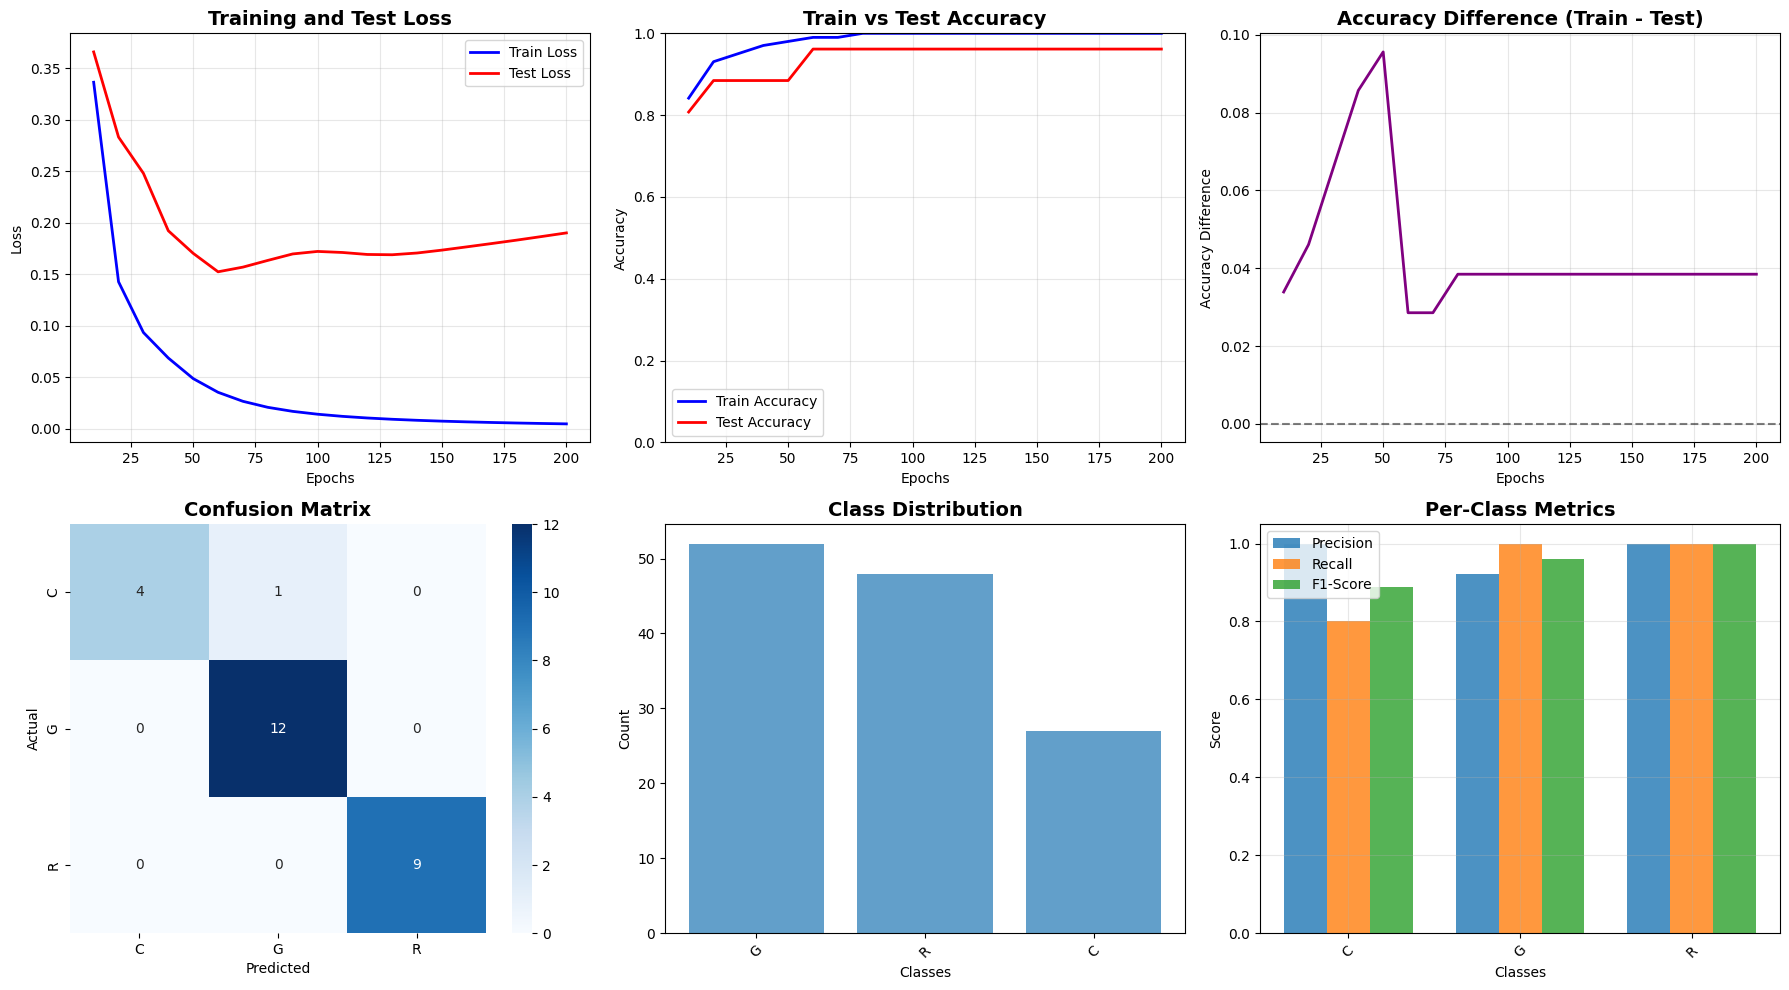


RELATÓRIO DE CLASSIFICAÇÃO
              precision    recall  f1-score   support

           C       1.00      0.80      0.89         5
           G       0.92      1.00      0.96        12
           R       1.00      1.00      1.00         9

    accuracy                           0.96        26
   macro avg       0.97      0.93      0.95        26
weighted avg       0.96      0.96      0.96        26


Acurácia Final: 0.9615
Loss Final (Treino): 0.0046
Loss Final (Teste): 0.1901


In [22]:
# Configurar o matplotlib para visualizações
plt.style.use('default')
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Curva de Loss
axes[0, 0].plot(epochs_recorded, train_losses, 'b-', label='Train Loss', linewidth=2)
axes[0, 0].plot(epochs_recorded, test_losses, 'r-', label='Test Loss', linewidth=2)
axes[0, 0].set_title('Training and Test Loss', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Comparação de Acurácia (Train vs Test)
axes[0, 1].plot(epochs_recorded, train_accuracies, 'b-', label='Train Accuracy', linewidth=2)
axes[0, 1].plot(epochs_recorded, test_accuracies, 'r-', label='Test Accuracy', linewidth=2)
axes[0, 1].set_title('Train vs Test Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylim([0, 1])

# 3. Diferença entre Train e Test Accuracy (Overfitting Detection)
accuracy_diff = np.array(train_accuracies) - np.array(test_accuracies)
axes[0, 2].plot(epochs_recorded, accuracy_diff, 'purple', linewidth=2)
axes[0, 2].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[0, 2].set_title('Accuracy Difference (Train - Test)', fontsize=14, fontweight='bold')
axes[0, 2].set_xlabel('Epochs')
axes[0, 2].set_ylabel('Accuracy Difference')
axes[0, 2].grid(True, alpha=0.3)

# 4. Matriz de Confusão
model.eval()
with torch.no_grad():
    final_outputs = model(X_test_tensor)
    _, final_predicted = torch.max(final_outputs.data, 1)

cm = confusion_matrix(y_test_tensor.numpy(), final_predicted.numpy())
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_,
            ax=axes[1, 0])
axes[1, 0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Actual')

# 5. Distribuição das Classes
class_counts = pd.Series(y).value_counts()
axes[1, 1].bar(class_counts.index, class_counts.values, alpha=0.7)
axes[1, 1].set_title('Class Distribution', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Classes')
axes[1, 1].set_ylabel('Count')
axes[1, 1].tick_params(axis='x', rotation=45)

# 6. Acurácia Final por Classe
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1, _ = precision_recall_fscore_support(y_test_tensor.numpy(), final_predicted.numpy(), average=None)
x_pos = np.arange(len(label_encoder.classes_))
width = 0.25

axes[1, 2].bar(x_pos - width, precision, width, label='Precision', alpha=0.8)
axes[1, 2].bar(x_pos, recall, width, label='Recall', alpha=0.8)
axes[1, 2].bar(x_pos + width, f1, width, label='F1-Score', alpha=0.8)
axes[1, 2].set_title('Per-Class Metrics', fontsize=14, fontweight='bold')
axes[1, 2].set_xlabel('Classes')
axes[1, 2].set_ylabel('Score')
axes[1, 2].set_xticks(x_pos)
axes[1, 2].set_xticklabels(label_encoder.classes_, rotation=45)
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Relatório de classificação detalhado
print("\n" + "="*50)
print("RELATÓRIO DE CLASSIFICAÇÃO")
print("="*50)
print(classification_report(y_test_tensor.numpy(), final_predicted.numpy(), 
                          target_names=label_encoder.classes_))

# Métricas finais
final_accuracy = (final_predicted == y_test_tensor).sum().item() / len(y_test_tensor)
print(f"\nAcurácia Final: {final_accuracy:.4f}")
print(f"Loss Final (Treino): {train_losses[-1]:.4f}")
print(f"Loss Final (Teste): {test_losses[-1]:.4f}")

# Teste do Modelo

In [31]:
import pandas as pd
import joblib
from sklearn.metrics import classification_report

# --- Step 1: Load the CSV file ---
csv_path = './test_fca.csv'
df = pd.read_csv(csv_path)

# --- Step 2: Extract features and labels ---
X = df.iloc[:, 3:].values        # Features: R1..B5, H1..V5 => shape (n_samples, 30)
y_true = df['class'].values      # True class labels (e.g., 'R', 'G', 'C')

# --- Step 3: Load the trained model ---
model = joblib.load('./pesos/mlp_model_2025-07-28_17-05-59.pkl')  # Update path/filename if needed

# --- Step 4: Predict using the model ---
y_pred = model.forward(X)

# --- Step 5: Output results ---
for idx, row in df.iterrows():
    print(f"{row['file_name']}: predicted={y_pred[idx]}, true={row['class']}")

# --- Optional: Print metrics ---
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred))


TypeError: linear(): argument 'input' (position 1) must be Tensor, not numpy.ndarray